In [1]:
import scanpy as sc
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scpert.config as config
from scpert.data import padding_data, source_target_multiclass_alignment, PertDataset
from torch.utils.data import DataLoader
from scpert.visualize import plot_alignment, plot_regression_plot
from scpert.training import train, independent_validate, validate
from scpert.model import PertNet, NetBase, FFNet
from scipy.stats import pearsonr
from socube.utils import getJobId, loadTorchModule

In [2]:
def unpadding_data(data: sc.AnnData):
    if "padding" in data.uns:
        old_var = data.var_names.drop(data.uns["padding"])
        data = data[:, old_var]
    return data

def predict(self, source: sc.AnnData, class_col: str, device: torch.device) -> sc.AnnData:
    pred_scPert = validate(
        DataLoader(PertDataset(source, source, class_col), batch_size=256),
        model=self,
        device=device)["predict"]
    pred_scPert = sc.AnnData(
        X=pred_scPert.detach().cpu().numpy(), 
        obs=source.obs, 
        var=source.var, 
        dtype=source.X.dtype)
    pred_scPert.obs["condition"] = self.__class__.__name__
    pred_scPert = unpadding_data(pred_scPert)
    return pred_scPert

def clear_data(data: sc.AnnData) -> sc.AnnData:
    return sc.AnnData(X=data.X, obs=data.obs, var=data.var, dtype=data.X.dtype)

setattr(NetBase, "predict", predict)

In [3]:
config.CTRL_COLOR = "#96A1A3"
config.PRED_COLOR = "#A4E804"
config.TARGET_COLOR = "#009FC2"
CLASS_COL = "cell_type"
plt.style.use("seaborn-white")
plt.rcParams["savefig.facecolor"] = "auto"
plt.rcParams["savefig.edgecolor"] = "auto"
sc.set_figure_params(fontsize=14, vector_friendly=True, dpi=300)

In [4]:
pbmc_train = sc.read_h5ad("datasets/scGEN/train_pbmc_clear.h5ad")
pbmc_train.obs.groupby(['condition', 'cell_type']).size()

condition   cell_type  
control     CD4T           2437
            CD14+Mono      1946
            B               818
            CD8T            574
            NK              517
            FCGR3A+Mono    1100
            Dendritic       615
stimulated  CD4T           3127
            CD14+Mono       615
            B               993
            CD8T            541
            NK              646
            FCGR3A+Mono    2501
            Dendritic       463
dtype: int64

In [5]:
pbmc_train_padding = padding_data(pbmc_train, 7000 - pbmc_train.shape[1])

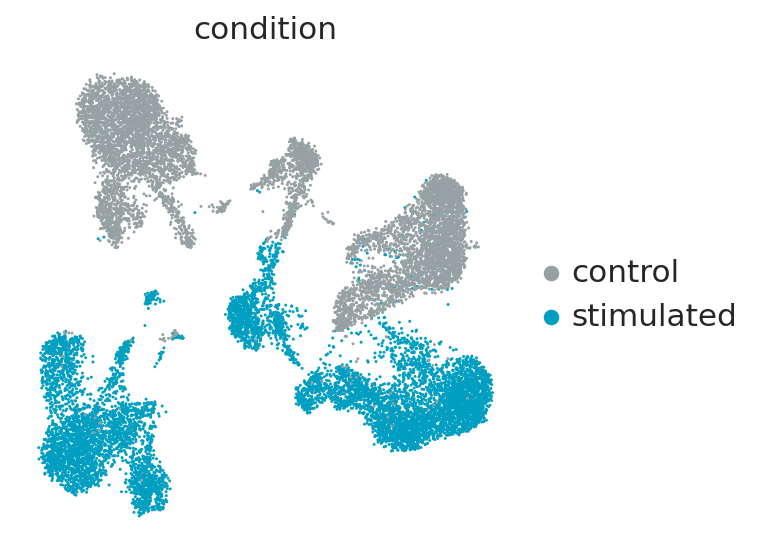

In [6]:
sc.pp.neighbors(pbmc_train)
sc.tl.umap(pbmc_train)
sc.pl.umap(pbmc_train, color=["condition"],
           legend_fontsize=14,
           palette=[config.CTRL_COLOR, config.TARGET_COLOR],
           save=f"_kang_pbmc_conditions.pdf",
           show=True, 
           frameon=False)

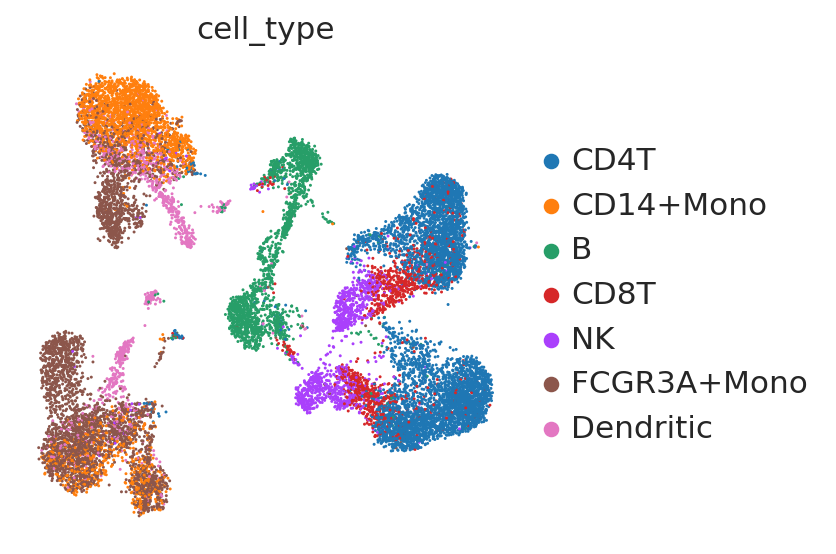

In [7]:
sc.pp.neighbors(pbmc_train)
sc.pl.umap(pbmc_train, color=["cell_type"],
           legend_fontsize=14,
           save=f"_kang_pbmc_celltypes.pdf",
           show=True, 
           frameon=False)

In [7]:
sc.pp.neighbors(pbmc_train_padding)
sc.tl.umap(pbmc_train_padding)
pbmc_train_source = pbmc_train_padding[pbmc_train_padding.obs["condition"] == config.SOURCE_NAME]
pbmc_train_target = pbmc_train_padding[pbmc_train_padding.obs["condition"] == config.TARGET_NAME]
cell_types = ["B", "CD4T", "CD8T", "CD14+Mono", "Dendritic", "FCGR3A+Mono", "NK"]

In [8]:
select_cell = "FCGR3A+Mono"

In [16]:
balance_source, balance_target = source_target_multiclass_alignment(
    pbmc_train_source, 
    pbmc_train_target, mertic="cosine",
    top_frac=1.0
    )
pearsonr(
    balance_source[balance_source.obs.cell_type == select_cell].X.toarray().flatten(), 
    balance_target[balance_target.obs.cell_type == select_cell].X.toarray().flatten())

2022-10-17 20:24:53,755 - Preprocess - INFO - Sample for CD8T
2022-10-17 20:24:54,515 - Preprocess - INFO - Sample for FCGR3A+Mono
2022-10-17 20:24:58,045 - Preprocess - INFO - Sample for B
2022-10-17 20:24:59,946 - Preprocess - INFO - Sample for CD14+Mono
2022-10-17 20:25:00,892 - Preprocess - INFO - Sample for NK
2022-10-17 20:25:01,529 - Preprocess - INFO - Sample for Dendritic
2022-10-17 20:25:02,064 - Preprocess - INFO - Sample for CD4T


(0.5383375551316629, 0.0)

... storing 'condition' as categorical
... storing 'cell_type' as categorical


<AxesSubplot:title={'center':'cell_type'}, xlabel='UMAP1', ylabel='UMAP2'>

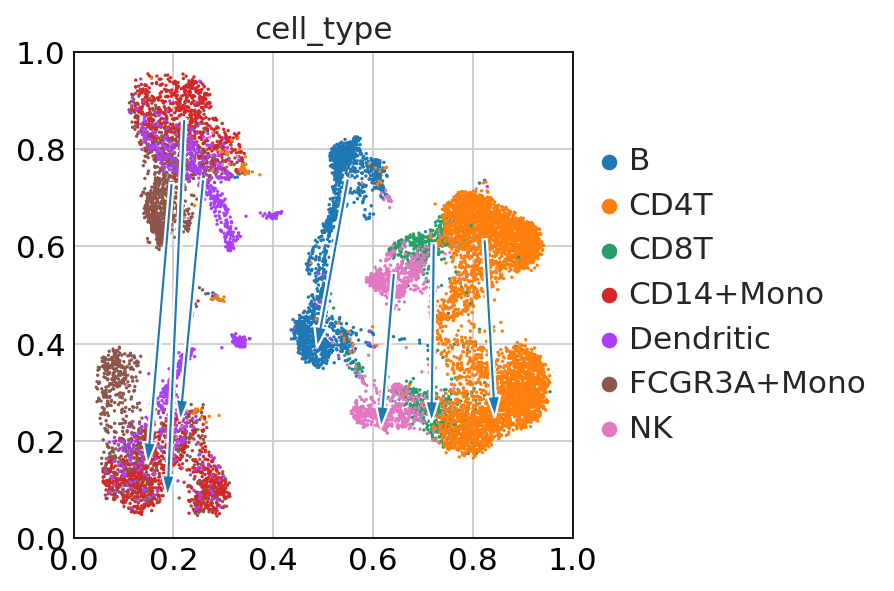

In [39]:
plot_alignment(
    balance_source, 
    balance_target,
    save_path="figures/umap_kang_pbmc_alignment.pdf")

In [7]:
import torch
import torch.nn as nn
import os
import torch.optim as optim

from torch.utils.data import DataLoader
from socube.utils import getJobId, mkDirs, visualBytes, autoClearIter
from socube.train import EarlyStopping
from tqdm.auto import tqdm
from scpert.training import validate
from scpert.model import  PertNet
from scpert.data import PertDataset

In [11]:
dataset = PertDataset(
    source=balance_source[balance_source.obs.cell_type != select_cell], 
    target=balance_target[balance_target.obs.cell_type != select_cell])
# dataset = PertDataset(source=pbmc_train, target=pbmc_train)
jobid = getJobId()
mkDirs(f"models/scPert/{jobid}/{select_cell}")
print(jobid)
n_epoches = 250
update_lr_step = 8
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from torch.utils.tensorboard.writer import SummaryWriter
for fold, (train_set, valid_set) in enumerate(dataset.kFold(seed=42), 1):
    trainloader = DataLoader(train_set, 64, sampler=dataset.sampler(train_set))
    validloader = DataLoader(valid_set, 256, sampler=dataset.sampler(valid_set))
    model = PertNet(140, 7000, 10, 6, 2)
    # model = FFNet(2000).to(device)
    # model.load_state_dict(torch.load("models/scPert/20220930-225411-915/SimpleTFNet_1.pt"))
    earlystop = EarlyStopping(
        path=f"models/scPert/{jobid}/{select_cell}/{model.__class__.__name__}_{fold}.pt",
        patience=10,
        verbose=10)

    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    torch.optim.lr_scheduler.CosineAnnealingWarmRestarts
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,
                                                        gamma=0.95)
    loop = tqdm(range(n_epoches))
    corr = validate(validloader, model, device)
    writer = SummaryWriter(f"logs/scPert/{jobid}/fold{fold}")
    for epoch in autoClearIter(loop):
        model.train()
        epoch_loss = []
        for index, batch in autoClearIter(enumerate(trainloader, 1)):
            source = batch["source"].to(device)
            target = batch["target"].to(device)
            optimizer.zero_grad()
            predict = model(source)
            loss = model.criterion(predict, target, source)
            loss.backward()
            optimizer.step()
            epoch_loss.append(loss.cpu().detach().item())
            loop.set_description("Fold %02d batch %03d/%03d" %
                                (fold, index, len(trainloader)))
            loop.set_postfix(
                train_loss = loss.cpu().detach().item(),
                valid_loss = corr["loss"],
                pearson = corr["pearson"],
                pid=str(os.getpid()),
                memo_res=visualBytes(
                    torch.cuda.memory_reserved(device)),
                max_memo_res=visualBytes(
                    torch.cuda.max_memory_reserved(device)),
                lr="%.06f" % (scheduler.get_last_lr()[0]))

            # del data, label, score, loss
        if (epoch + 1) % 5 == 0:
            scheduler.step()

        corr = validate(validloader, model, device)
        print("[Epoch %d/%d] Train loss: %.6f, Valid loss %.6f, Corr: %.4f"%(
                epoch,
                n_epoches,
                np.mean(epoch_loss),
                corr["loss"],
                corr["pearson"]
            ))

        earlystop(corr["loss"], model)

        writer.add_scalar(
            tag="Train Loss", 
            scalar_value=np.mean(epoch_loss),
            global_step=epoch)

        writer.add_scalar(
            tag="Valid Loss",
            scalar_value=corr["loss"],
            global_step=epoch
        )

        writer.add_scalar(
            tag="Pearson corr",
            scalar_value=corr["pearson"],
            global_step=epoch
        )

        if earlystop.earlyStop:
            print(f"Early stopping at epoch {epoch} for fold {fold}")
            break
    writer.close()
    break

20221012-223938-179


  0%|          | 0/250 [00:00<?, ?it/s]

[Epoch 0/250] Train loss: 8.847967, Valid loss 6.893437, Corr: 0.1841
[Epoch 1/250] Train loss: 4.349440, Valid loss 3.419071, Corr: 0.4270
[Epoch 2/250] Train loss: 3.338189, Valid loss 3.132646, Corr: 0.4319
[Epoch 3/250] Train loss: 2.785041, Valid loss 2.507871, Corr: 0.5087
[Epoch 4/250] Train loss: 2.350067, Valid loss 2.256809, Corr: 0.5312
[Epoch 5/250] Train loss: 2.117496, Valid loss 1.960225, Corr: 0.6066
[Epoch 6/250] Train loss: 1.873794, Valid loss 1.790305, Corr: 0.6580
[Epoch 7/250] Train loss: 1.726164, Valid loss 1.661559, Corr: 0.6725
[Epoch 8/250] Train loss: 1.617757, Valid loss 1.555868, Corr: 0.7124
[Epoch 9/250] Train loss: 1.513839, Valid loss 1.485791, Corr: 0.7155
[Epoch 10/250] Train loss: 1.436323, Valid loss 1.400033, Corr: 0.7463
[Epoch 11/250] Train loss: 1.371240, Valid loss 1.343670, Corr: 0.7606
[Epoch 12/250] Train loss: 1.304577, Valid loss 1.271405, Corr: 0.7848
[Epoch 13/250] Train loss: 1.247246, Valid loss 1.234008, Corr: 0.8000
[Epoch 14/250] T

In [8]:
import scgen
import seaborn as sns

from scpert.visualize  import plot_regression_plot
from socube.utils import mkDirs, loadTorchModule

2022-10-18 21:23:03,826 - torch.distributed.nn.jit.instantiator - INFO - Created a temporary directory at /tmp/tmp9vua5jxv
2022-10-18 21:23:03,827 - torch.distributed.nn.jit.instantiator - INFO - Writing /tmp/tmp9vua5jxv/_remote_module_non_scriptable.py
2022-10-18 21:23:04,106 - pytorch_lightning.utilities.seed - INFO - Global seed set to 0
/home/hongning/anaconda3/envs/scgen-env/lib/python3.7/site-packages/pytorch_lightning/utilities/warnings.py:54: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  "pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6"
/home/hongning/anaconda3/envs/scgen-env/lib/python3.7/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1

In [9]:
all_merge = None

for index, select_cell in enumerate(cell_types + ["all"]):
    if select_cell != "all":
        source_data = pbmc_train_source[pbmc_train_source.obs.cell_type == select_cell]
        target_data = pbmc_train_target[pbmc_train_target.obs.cell_type == select_cell]
        scpert = PertNet(140, 7000, 10, 6, 2)
        scpert = loadTorchModule(scpert, f"models/scPert/20221013-222528-643/{select_cell}/{scpert.__class__.__name__}_1.pt", skipped=False)
        scpert = scpert.to(torch.device("cpu"))
        mkDirs(f"outputs/scPert/20221013-222528-643/{select_cell}")
        ffnet = FFNet(6998)
        ffnet = loadTorchModule(ffnet, f"models/FFNet/20221018-202400-242/{select_cell}/{ffnet.__class__.__name__}_1.pt", skipped=False)
        ffnet = ffnet.to(torch.device("cpu"))
        mkDirs(f"outputs/scPert/20221018-202400-242/{select_cell}")

        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        pred_scPert = scpert.predict(source_data, CLASS_COL, device)
        source_data = unpadding_data(source_data)
        target_data = unpadding_data(target_data)
        pred_ffnet = ffnet.predict(source_data, CLASS_COL, device)
        scgen_model = scgen.SCGEN.load(f"models/scGEN/20221014-155243-964/{select_cell}/model_perturbation_prediction_all", pbmc_train)
        pred_scgen, delta = scgen_model.predict(
            ctrl_key=config.SOURCE_NAME,
            stim_key=config.TARGET_NAME,
            celltype_to_predict=select_cell
        )
        pred_scgen.obs['condition'] = "scGEN"
        merge = sc.concat([source_data, target_data, pred_scPert, pred_scgen, pred_ffnet])
        if all_merge is None:
            all_merge = merge
        else:
            all_merge = all_merge.concatenate(merge)
    else:
        merge = all_merge
    merge.obsm.clear()
    merge.obs_names_make_unique()

sc.write(f"outputs/all_merge.h5ad", all_merge)

2022-10-18 21:23:18,322 - loadTorchModule - INFO - model models/scPert/20221013-222528-643/B/PertNet_1.pt loaded
2022-10-18 21:23:18,718 - loadTorchModule - INFO - model models/FFNet/20221018-202400-242/B/FFNet_1.pt loaded


INFO     File models/scGEN/20221014-155243-964/B/model_perturbation_prediction_all/model.pt already downloaded     
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/hongning/anaconda3/envs/scgen-env/lib/python3.7/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


2022-10-18 21:23:30,713 - loadTorchModule - INFO - model models/scPert/20221013-222528-643/CD4T/PertNet_1.pt loaded
2022-10-18 21:23:31,090 - loadTorchModule - INFO - model models/FFNet/20221018-202400-242/CD4T/FFNet_1.pt loaded


INFO     File models/scGEN/20221014-155243-964/CD4T/model_perturbation_prediction_all/model.pt already downloaded  
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/hongning/anaconda3/envs/scgen-env/lib/python3.7/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
2022-10-18 21:23:53,381 - loadTorchModule - INFO - model models/scPert/20221013-222528-643/CD8T/PertNet_1.pt loaded
2022-10-18 21:23:53,815 - loadTorchModule - INFO - model models/FFNet/20221018-202400-242/CD8T/FFNet_1.pt loaded


INFO     File models/scGEN/20221014-155243-964/CD8T/model_perturbation_prediction_all/model.pt already downloaded  
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


2022-10-18 21:24:00,939 - loadTorchModule - INFO - model models/scPert/20221013-222528-643/CD14+Mono/PertNet_1.pt loaded
2022-10-18 21:24:02,151 - loadTorchModule - INFO - model models/FFNet/20221018-202400-242/CD14+Mono/FFNet_1.pt loaded


INFO     File models/scGEN/20221014-155243-964/CD14+Mono/model_perturbation_prediction_all/model.pt already        
         downloaded                                                                                                
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


2022-10-18 21:24:21,140 - loadTorchModule - INFO - model models/scPert/20221013-222528-643/Dendritic/PertNet_1.pt loaded
2022-10-18 21:24:22,993 - loadTorchModule - INFO - model models/FFNet/20221018-202400-242/Dendritic/FFNet_1.pt loaded


INFO     File models/scGEN/20221014-155243-964/Dendritic/model_perturbation_prediction_all/model.pt already        
         downloaded                                                                                                
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


2022-10-18 21:24:30,456 - loadTorchModule - INFO - model models/scPert/20221013-222528-643/FCGR3A+Mono/PertNet_1.pt loaded
2022-10-18 21:24:32,437 - loadTorchModule - INFO - model models/FFNet/20221018-202400-242/FCGR3A+Mono/FFNet_1.pt loaded


INFO     File models/scGEN/20221014-155243-964/FCGR3A+Mono/model_perturbation_prediction_all/model.pt already      
         downloaded                                                                                                
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


2022-10-18 21:24:46,994 - loadTorchModule - INFO - model models/scPert/20221013-222528-643/NK/PertNet_1.pt loaded
2022-10-18 21:24:49,437 - loadTorchModule - INFO - model models/FFNet/20221018-202400-242/NK/FFNet_1.pt loaded


INFO     File models/scGEN/20221014-155243-964/NK/model_perturbation_prediction_all/model.pt already downloaded    
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


... storing 'condition' as categorical
... storing 'cell_type' as categorical


/home/hongning/anaconda3/envs/scgen-env/lib/python3.7/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/home/hongning/anaconda3/envs/scgen-env/lib/python3.7/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/home/hongning/anaconda3/envs/scgen-env/lib/python3.7/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/home/hongning/anaconda3/envs/scgen-env/lib/python3.7/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/home/hongning/anaconda3/envs/scgen-env/lib/python3.7/site-p

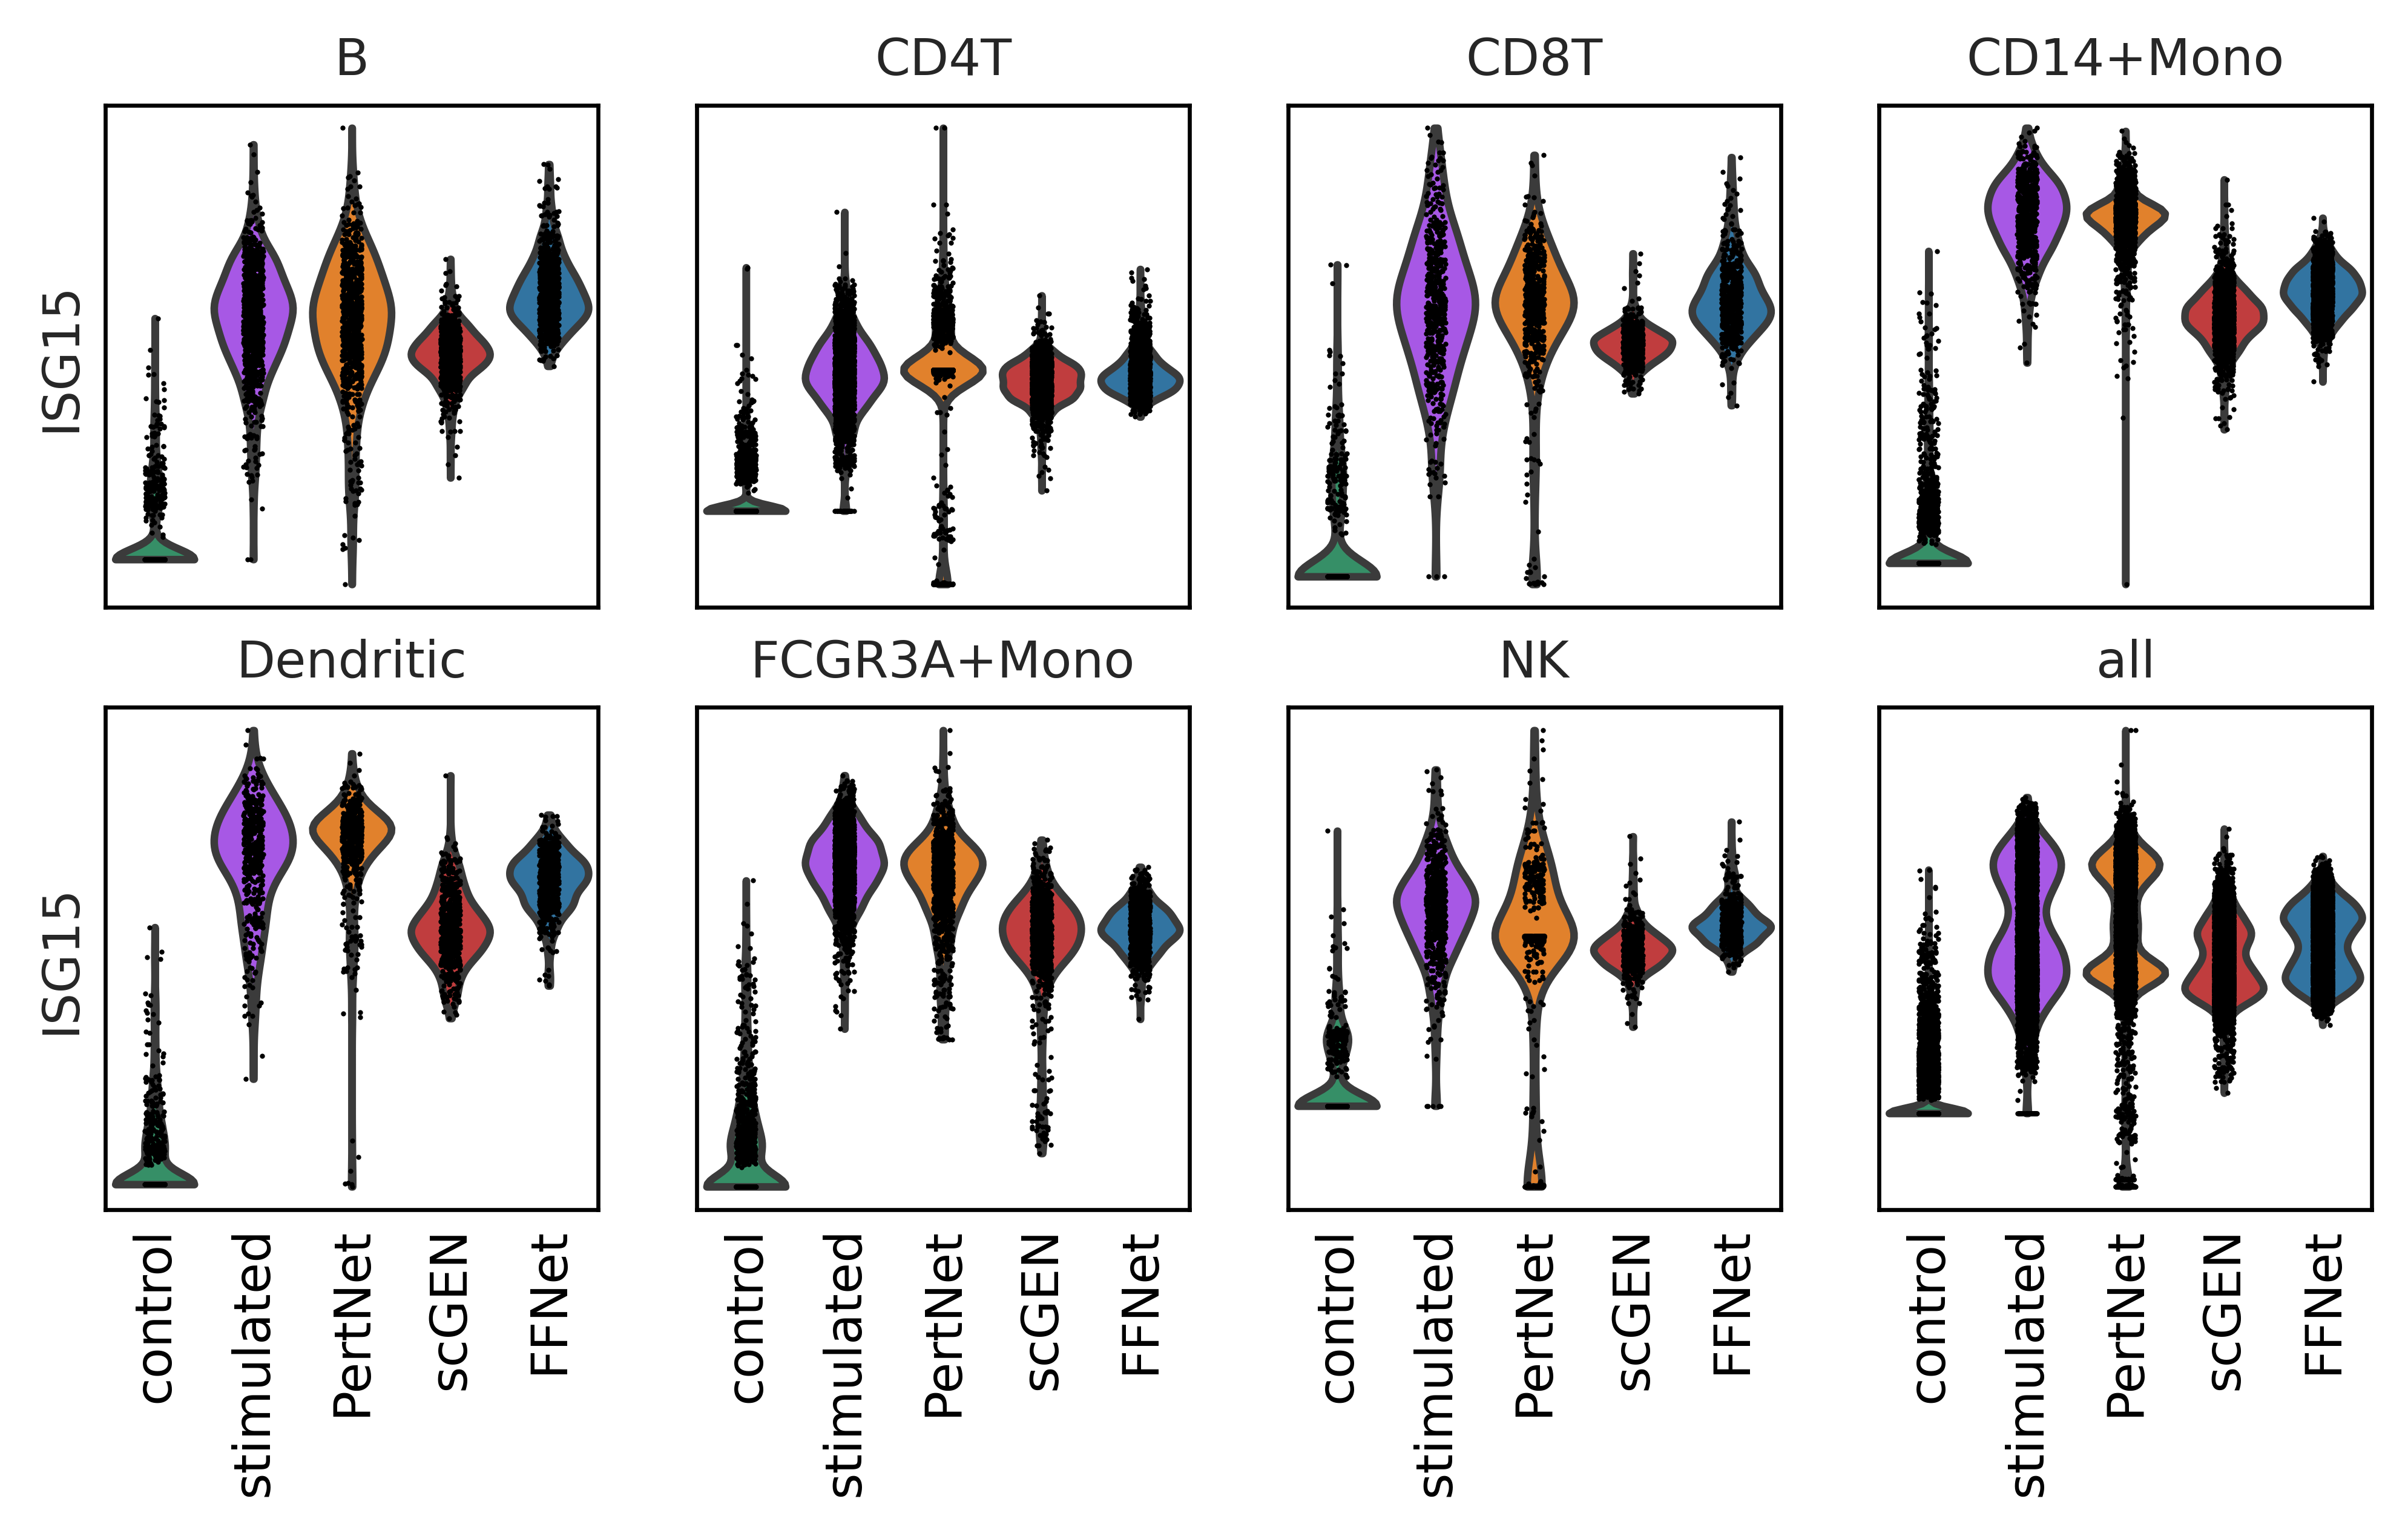

In [10]:
plt.close("all")
fig, axes = plt.subplots(2, 4, figsize=(8, 4))
axes = axes.flatten()
for index, select_cell in enumerate(cell_types + ["all"]):
    axes[index].set_title(select_cell, fontsize=10)
    axes[index].tick_params(labelsize=10)
    if select_cell != "all":
        merge = all_merge[all_merge.obs.cell_type == select_cell]
    else:
        merge = all_merge
    sc.pl.violin(merge,
                keys="ISG15", 
                groupby="condition", 
                rotation=90,
                show=False,
                order=merge.obs["condition"].unique().tolist(),
                color = "#ee0ef0",
                ax=axes[index])
    axes[index].set_yticks([])
    axes[index].set_ylabel("" if index % 4 != 0 else "ISG15", fontsize=10)
    if index < 4:
        axes[index].set_xticks([])

plt.savefig("figures/violin_conpare.pdf", dpi=300)

In [11]:
data = {
    "R^2": [0.9,0.92,0.94,0.94,0.91,0.96,0.91, 0.93] + 
            [0.93,0.89,0.92,0.9,0.94,0.91,0.9,0.91] +
            [0.83,0.86,0.92,0.91,0.89,0.94,0.83,0.88],
    "Methods":["scPert"] * 8 + ["scGEN"] * 8 + ["FFNet"] * 8,
    "cell_types":(cell_types + ["Average"]) * 3
}
data = pd.DataFrame(data)

data_top_100 = {
    "R^2": [0.99,0.98,1,0.95,0.93,0.97,0.95,0.97] + 
        [0.92,0.84,0.9,0.85,0.93,0.87,0.87,0.88] +
        [0.94,0.96,0.97,0.92,0.91,0.99,0.8,0.93],
    "Methods":["scPert"] * 8 + ["scGEN"] * 8 + ["FFNet"] * 8,
    "cell_types":(cell_types + ["Average"]) * 3
}
data_top_100 = pd.DataFrame(data_top_100)

In [29]:
import matplotlib
def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width() / 2., 1.01 * height,
                '%.2f' % float(height),
                ha='center', va='bottom', fontsize=18)

def grouped_barplot(df, cat, subcat, val, err=None, filename=None, put_label=False, legend=False, ylim=None):
    plt.close("all")
    matplotlib.rc('ytick', labelsize=25)
    matplotlib.rc('xtick', labelsize=30)
    u = df[cat].unique()
    subx = df[subcat].unique()
    x_pos = np.arange(0, len(subx)*len(u), len(subx))
    plt.figure(figsize=(12, 10))
    if ylim:
        plt.ylim(*ylim)
    plt.yticks([0.8, 0.85, 0.9, 0.95, 1.0])
    for i, gr in enumerate(subx):
        dfg = df[df[subcat] == gr]
        b = plt.bar(x_pos + i/1.25, dfg[val].values, capsize=10, alpha=0.95, label=f"{gr}", yerr=dfg[err].values if err else None)
        if err:
            a=np.random.normal(dfg[val].values, dfg[err].values, (10, len(u)))
            plt.plot(x_pos + i/1.25, a.T, '.', color='black', alpha=0.5)
        if put_label:
            autolabel(b)
    
    plt.ylabel(r"$\mathrm{R^2}$", fontsize=25)
    plt.xticks(x_pos+(len(subx) - 1) / 2.5, u, rotation=90)
    if legend:
        plt.legend(bbox_to_anchor=(1.05,0.5), loc="center left", borderaxespad=0, prop={'size': 18})
    plt.tight_layout()
    if filename:
        plt.savefig(filename, dpi=300, facecolor='auto', edgecolor='auto')
    plt.show()

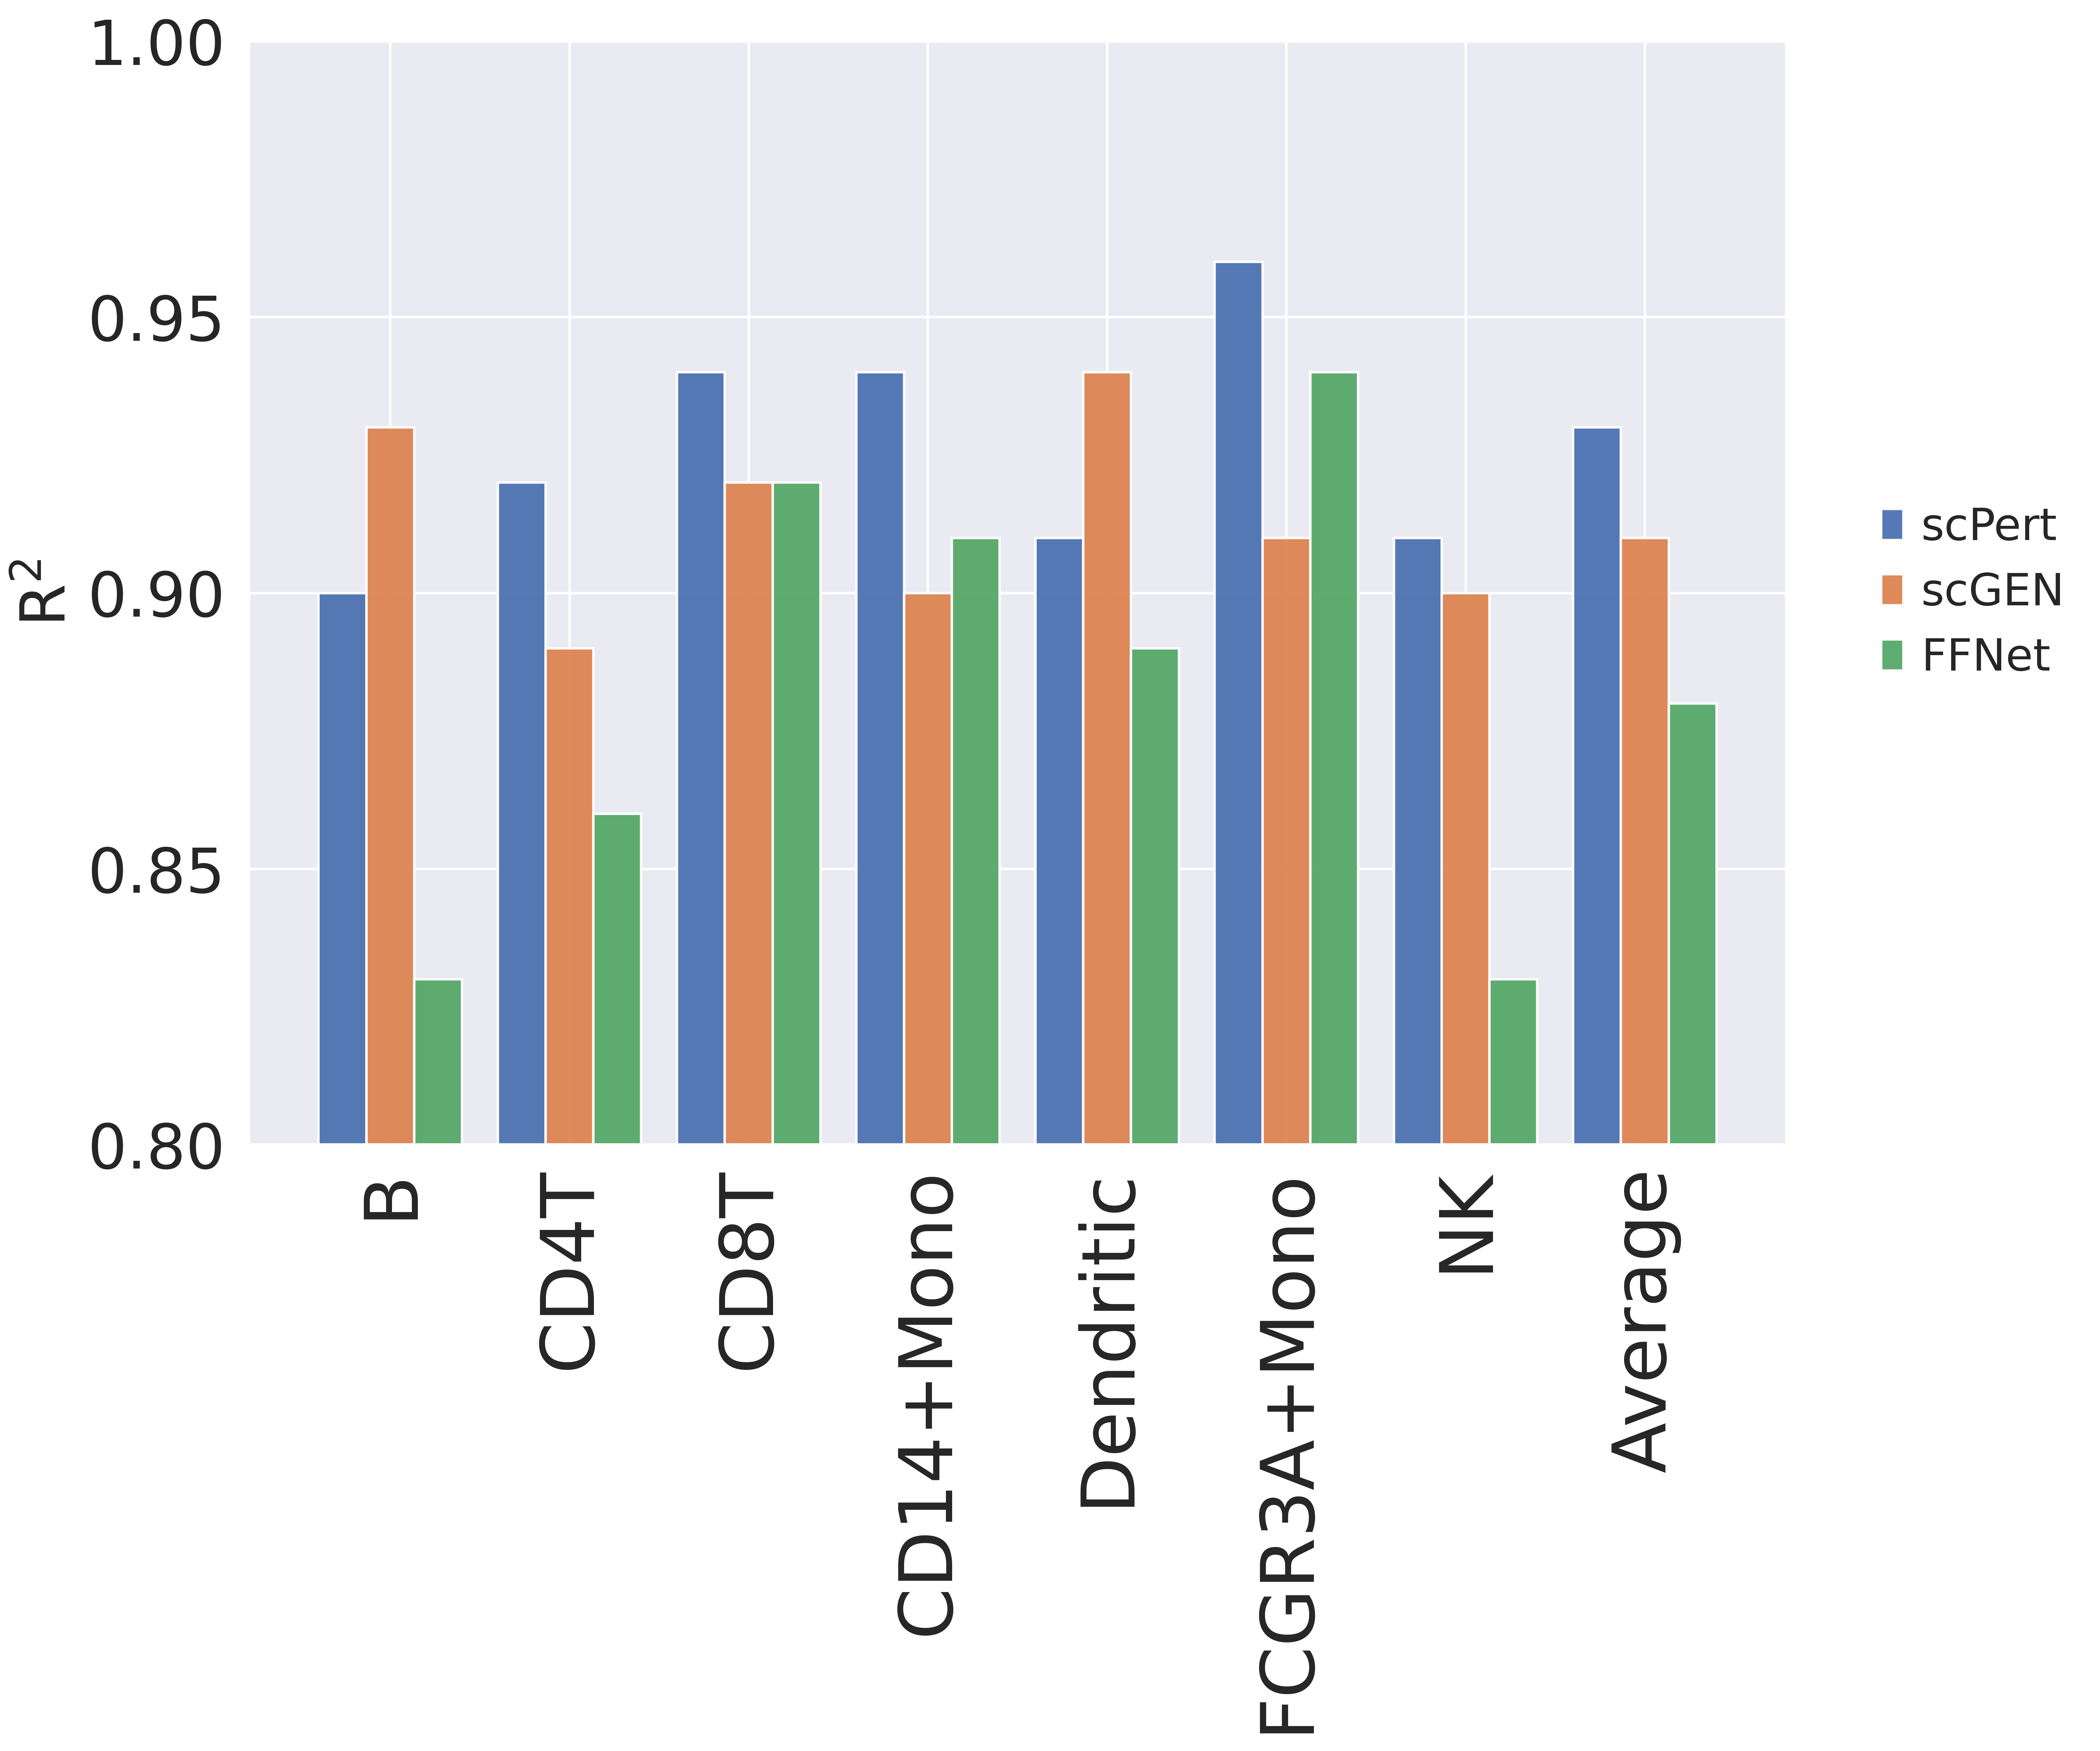

In [30]:
import seaborn as sns
sns.set()
grouped_barplot(
    data, 
    "cell_types", 
    "Methods", 
    "R^2", 
    None, 
    legend=True, 
    filename="figures/scPert/20221013-222528-643/pbmc_kang_celltypes_barplots[all].pdf",
    ylim=(0.8, 1.0))

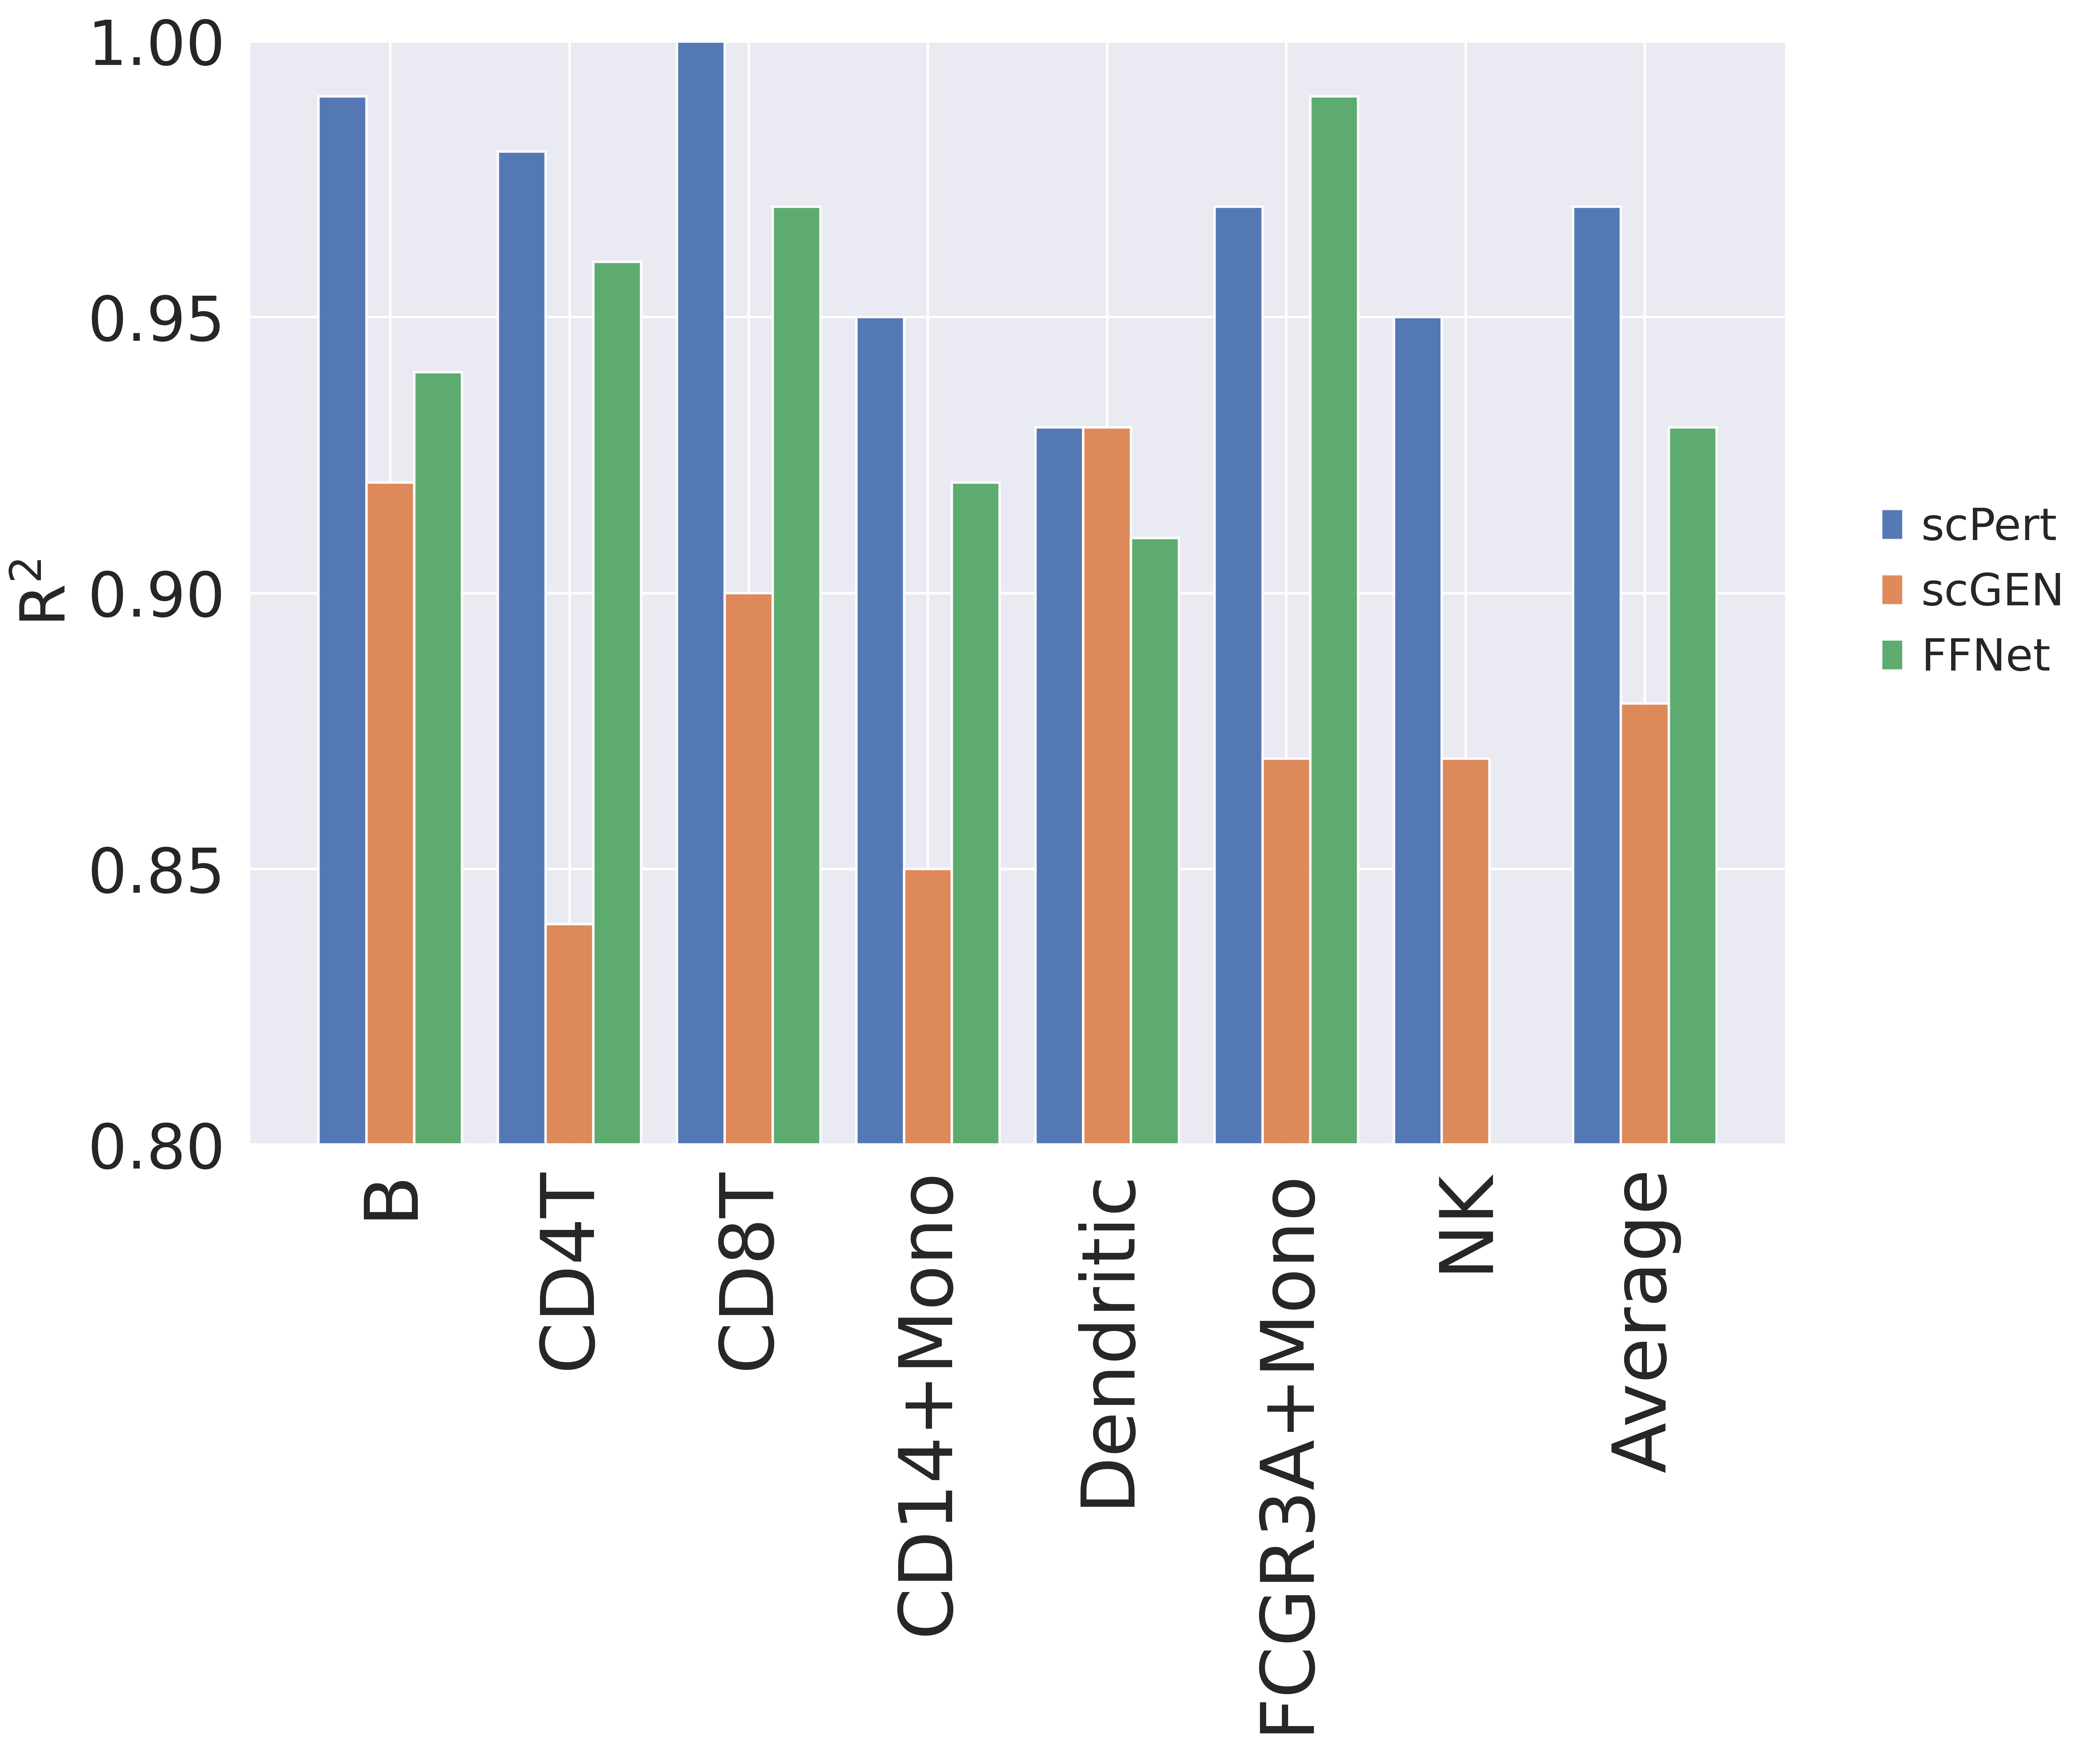

In [31]:
grouped_barplot(
    data_top_100,
    "cell_types", 
    "Methods", 
    "R^2", 
    None, 
    legend=True, 
    filename="figures/scPert/20221013-222528-643/pbmc_kang_celltypes_barplots[top 100 DEG].pdf",
    ylim=(0.8, 1.0))

### scGEN

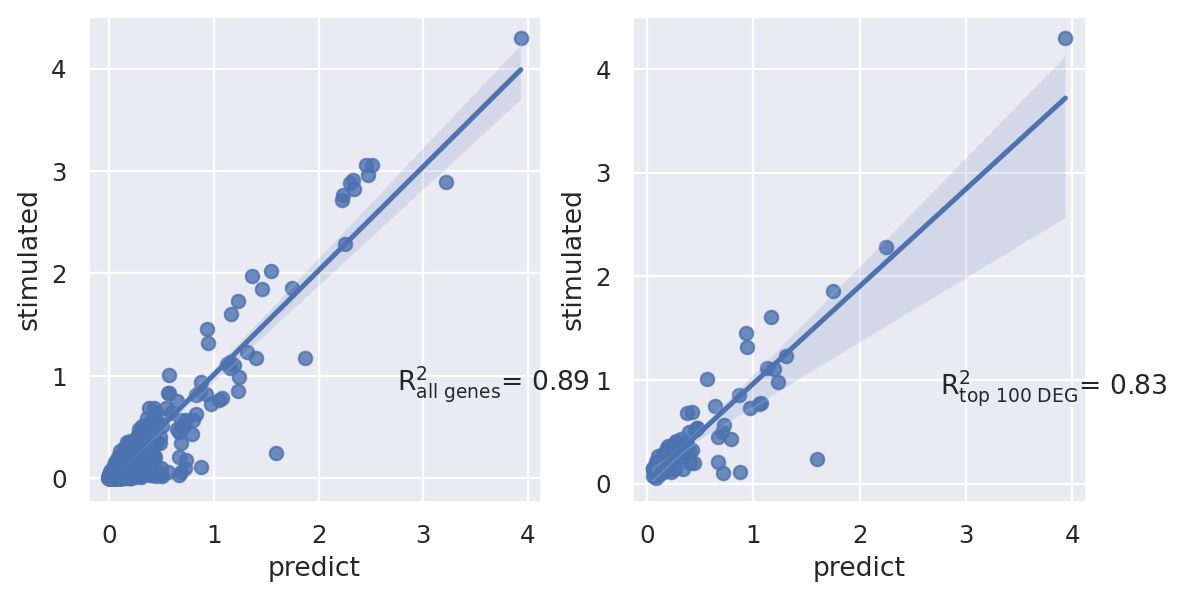

In [92]:
plot_regression_plot(pred_scgen, target_data, diff_genes[:100], X_label="Predict by scGEN", Y_label=target_name)